### BAIS:3250 Data Wrangling Final Project - *Analyzing Trends and Clustering in S&P 500 Stock Data*
> ##### Team Members: Brady Hunter, Michael Swaim
> ##### Date: April 27, 2025

---

#### Introduction

In this project, we explore historical stock data for S&P 500 companies to uncover trends across sectors, test investment-related hypotheses, and apply unsupervised/supervised
machine learning for clustering.  
We focus on the following tasks:

>- Univariate and bivariate analysis of stock prices and sectors
>- Statistical hypothesis testing
>- Machine learning using KMeans clustering

---

#### Dataset Description

The dataset `cleaned_sp500_data.csv` contains merged information from:

>- S&P 500 company listings scraped from Wikipedia
>- Historical stock prices from Yahoo Finance

Each record includes company name, sector, stock prices (open, high, low, close), volume, and other key attributes.


Dataset loaded: 56158 rows, 11 columns


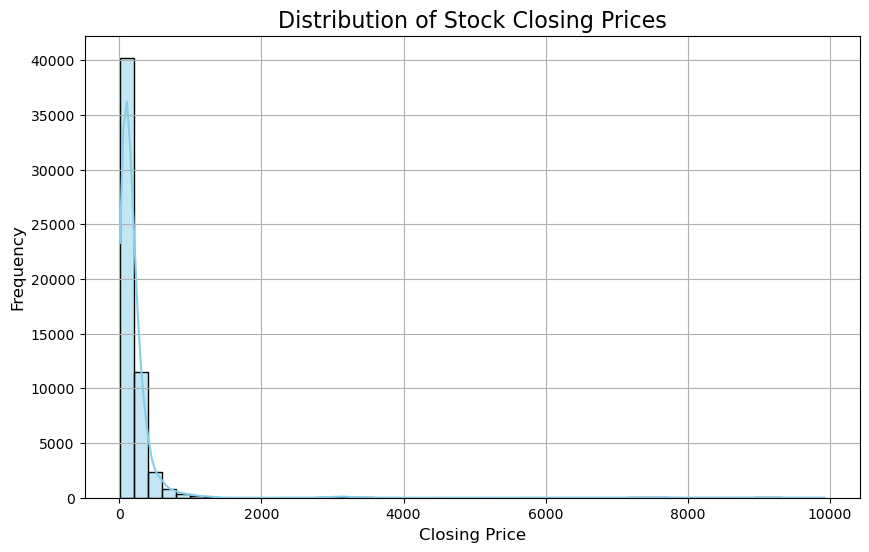

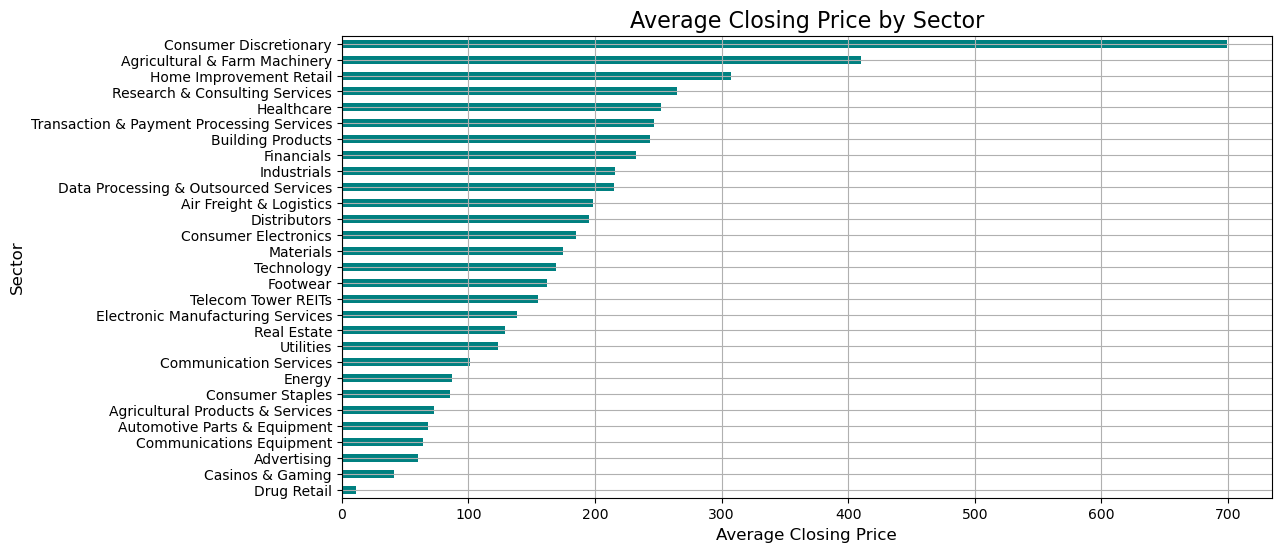


--- Hypothesis Test Results ---
T-statistic: -25.1141
P-value: 0.0000
→ Reject the null hypothesis: Sector mean closing prices are significantly different.


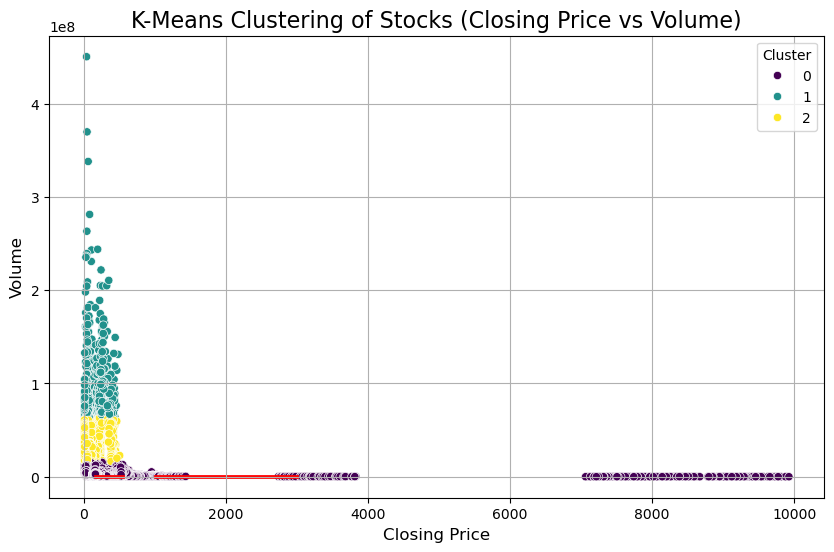

In [1]:

# 1. Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.cluster import KMeans

# 2. Load Cleaned Dataset
cleaned_df = pd.read_csv("cleaned_sp500_data.csv")
print(f"Dataset loaded: {cleaned_df.shape[0]} rows, {cleaned_df.shape[1]} columns")

# 3. Univariate Analysis: Distribution of Closing Prices
plt.figure(figsize=(10,6))
sns.histplot(cleaned_df['Close'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Stock Closing Prices', fontsize=16)
plt.xlabel('Closing Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()

# 4. Bivariate Analysis: Average Closing Price by Sector
sector_avg = cleaned_df.groupby('Sector')['Close'].mean().sort_values()

plt.figure(figsize=(12,6))
sector_avg.plot(kind='barh', color='teal')
plt.title('Average Closing Price by Sector', fontsize=16)
plt.xlabel('Average Closing Price', fontsize=12)
plt.ylabel('Sector', fontsize=12)
plt.grid(True)
plt.show()

# 5. Hypothesis Test: Technology vs Healthcare Sector Closing Prices
# Null Hypothesis (H0): Mean closing prices are the same across Technology and Healthcare sectors
# Alternative Hypothesis (H1): Mean closing prices differ between Technology and Healthcare sectors

# Extract closing prices for the two sectors
tech_returns = cleaned_df[cleaned_df['Sector'] == 'Technology']['Close']
healthcare_returns = cleaned_df[cleaned_df['Sector'] == 'Healthcare']['Close']

# Perform independent two-sample t-test
t_stat, p_val = ttest_ind(tech_returns, healthcare_returns, nan_policy='omit')

# Display Hypothesis Test Results
print("\n--- Hypothesis Test Results ---")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")
if p_val < 0.05:
    print("→ Reject the null hypothesis: Sector mean closing prices are significantly different.")
else:
    print("→ Fail to reject the null hypothesis: No significant difference between sector means.")

# 6. Machine Learning: KMeans Clustering (Close Price and Volume)
# Objective: Identify natural groupings of stocks based on price and trading volume

# Select features and drop any missing values
ml_df = cleaned_df[['Close', 'Volume']].dropna()

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(ml_df)

# Assign clusters back to the DataFrame
ml_df['Cluster'] = clusters

# Visualize KMeans Clusters with Highlighted Regions
plt.figure(figsize=(10,6))
sns.scatterplot(x='Close', y='Volume', hue='Cluster', palette='viridis', data=ml_df)
plt.title('K-Means Clustering of Stocks (Closing Price vs Volume)', fontsize=16)
plt.xlabel('Closing Price', fontsize=12)
plt.ylabel('Volume', fontsize=12)

# Adding boxes to highlight significant clusters
# Example coordinates for the box (x, y, width, height), adjust based on your data analysis
highlight_boxes = [
    (150, 100000, 400, 1000000),  # Example: Cluster 0
    (1000, 50000, 2000, 200000)   # Example: Cluster 1
]

# Draw rectangles on the plot
for box in highlight_boxes:
    plt.gca().add_patch(plt.Rectangle(
        (box[0], box[1]), box[2], box[3], linewidth=2, edgecolor='r', facecolor='none'
    ))

plt.legend(title='Cluster')
plt.grid(True)
plt.show()

### Forecasting Stock Prices with ARIMA
---
We use the ARIMA model to forecast the closing prices of 3M (MMM). ARIMA (AutoRegressive Integrated Moving Average) is a classical time series forecasting method that works well with stock data exhibiting trends without requiring seasonality modeling.


C:\Users\H728330\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\H728330\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\H728330\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\H728330\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer

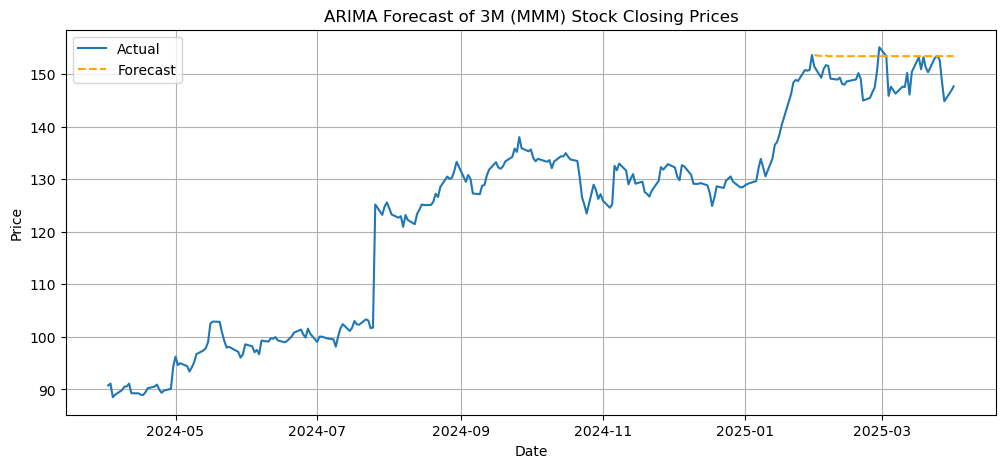

In [2]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Filter for 3M stock and prepare the time series
mmm_df = cleaned_df[cleaned_df['Symbol'] == 'MMM'].copy()
mmm_df['Date'] = pd.to_datetime(mmm_df['Date'])
mmm_df = mmm_df.sort_values('Date')
ts = mmm_df.set_index('Date')['Close'].dropna()

# Train on 10 months of data (~210 trading days)
train_ts = ts.iloc[:-42]
test_ts = ts.iloc[-42:]

# Fit ARIMA model (you can tune order if needed)
model = ARIMA(train_ts, order=(5, 1, 0))  # (p,d,q)
fitted_model = model.fit()

# Forecast next 42 trading days
forecast = fitted_model.forecast(steps=42)

# Plot
plt.figure(figsize=(12,5))
plt.plot(ts.index, ts, label='Actual')
plt.plot(test_ts.index, forecast, label='Forecast', linestyle='--', color='orange')
plt.title('ARIMA Forecast of 3M (MMM) Stock Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


AIC: 937.8107673531094
BIC: 957.8359958313174


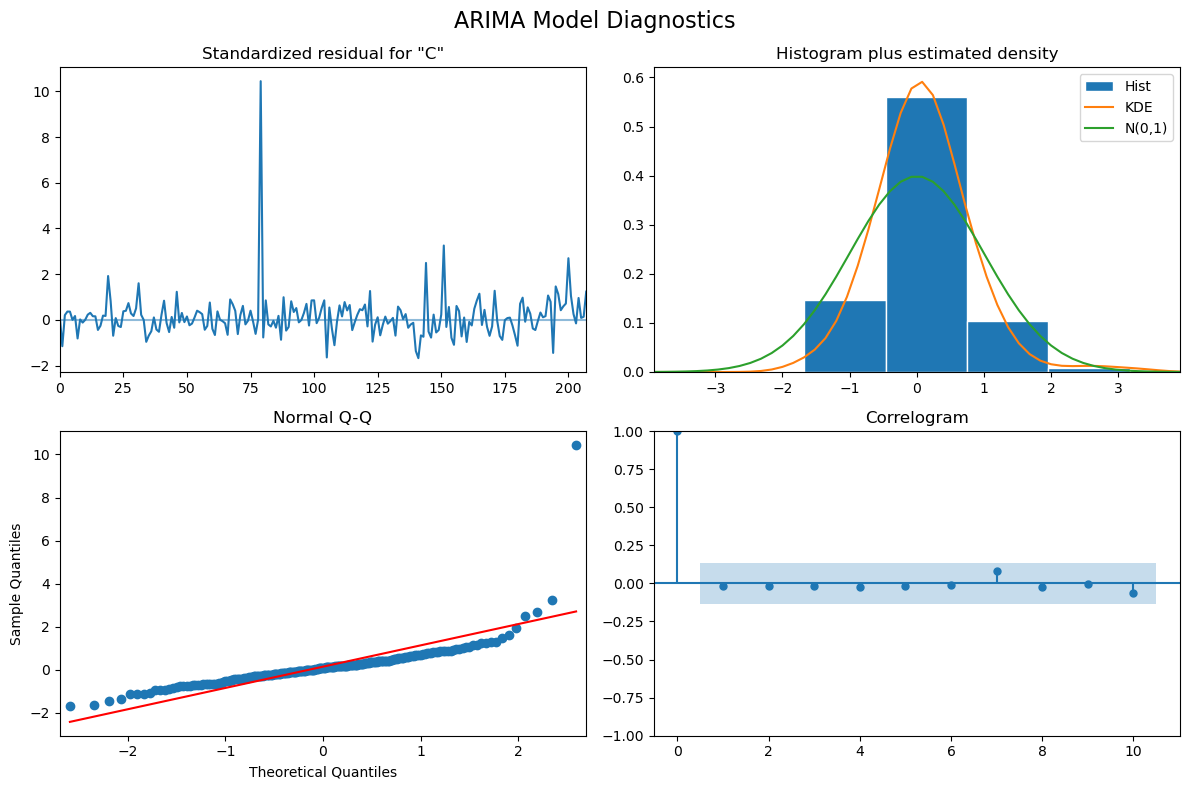

In [3]:
# AIC and BIC scores
print(f"AIC: {fitted_model.aic}")
print(f"BIC: {fitted_model.bic}")

# Diagnostic plots
fitted_model.plot_diagnostics(figsize=(12, 8))
plt.suptitle('ARIMA Model Diagnostics', fontsize=16)
plt.tight_layout()
plt.show()


### Predicting Quarterly Stock Movement with Supervised Learning
---

In this section, we use **logistic regression** to predict whether the stock price for 3M (MMM) will increase over the next quarter (63 trading days). This is a binary classification problem where:
- **1 = Gain** (stock price increased)
- **0 = No Gain/Loss** (stock price remained the same or decreased)

We will use the **previous quarter's closing price** as the feature and the **percent change** over the next quarter as the target variable.

#### Model Training:
- We create a feature based on the previous quarter's stock price.
- The target variable is a binary indicator (1 or 0) of whether the stock gained in the following quarter.

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Compute quarter return and label
mmm_df = mmm_df.sort_values('Date').reset_index(drop=True)
mmm_df['quarter_return'] = mmm_df['Close'].pct_change(periods=63)
mmm_df['label'] = (mmm_df['quarter_return'] > 0).astype(int)

# Shift close price to simulate features from past quarter
mmm_df['Close_prev_q'] = mmm_df['Close'].shift(63)
model_df = mmm_df.dropna(subset=['Close_prev_q', 'label'])

# Define X (previous quarter's price) and y (target label)
X = model_df[['Close_prev_q']]
y = model_df['label']

# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Train logistic regression model
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Loss/No Gain', 'Gain']))


              precision    recall  f1-score   support

Loss/No Gain       1.00      0.29      0.44         7
        Gain       0.86      1.00      0.93        31

    accuracy                           0.87        38
   macro avg       0.93      0.64      0.68        38
weighted avg       0.89      0.87      0.84        38



<small>
    
- **Class Imbalance:** The model has significantly more "Gain" instances (31) than "Loss/No Gain" (7), which may skew the results. In real-world scenarios, class imbalance is a common challenge.
- **Precision vs Recall Trade-off:** The high precision for "Loss/No Gain" (1.00) and low recall (0.29) suggests the model is not identifying most "Loss/No Gain" instances, but when it does, it's almost always correct.
- **Recall of 1.00 for "Gain":** The model correctly identified all "Gain" instances, which is excellent, but it’s worth investigating if the model is biased toward predicting "Gain" more often.
- **Model Improvements:** Future work could include addressing class imbalance (e.g., using **SMOTE** or adjusting **class weights**) or exploring more complex models like **Random Forests** or **XGBoost**.
  
</small>
